# Ритейл — Анализ программы лояльности

**Задача - проанализировать программу лояльности магазина.**

**Материалы:**

[Презентация](https://disk.yandex.ru/i/9yMJjtfTsaNN9g)
    
[Дашборд](https://public.tableau.com/app/profile/anastasiya.z7758/viz/Stroili/Dashboard1?publish=yes)

## Загрузим данные и подготовим их к анализу

In [ ]:
import pandas as pd
import numpy as np
import datetime   as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import norm
import plotly.graph_objects as go
import math as mth
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

In [ ]:
try:
    price = pd.read_csv('product_codes.csv', sep=',')
    retail = pd.read_csv('retail_dataset.csv', sep=',')
except:
    price = pd.read_csv('/datasets/product_codes.csv', sep=',')
    retail = pd.read_csv('/datasets/retail_dataset.csv', sep=',')


## Изучим данные и выполним предобработку

In [ ]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


2 столбца: продукт и цена за единицу товара

In [ ]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


6 столбцов: номер чека, продукт, количество, дата покупки, покупатель, магазин, участие в программе лояльности.

Необходимо привести столбцы с датой к типу дата, идентификационный номер покупателя к целочисленному типу, предварительно заменив пропуски, если есть. Столбец loyalty_program привести к типу int

### Переименуем столбцы

In [ ]:
retail.columns = map(str.lower, retail.columns) #приведем названия столбцов к нижнему регистру

In [ ]:
#переименуем столбцы для удобства
price = price.rename(columns={'productID':'item', ' price_per_one':'price'})
retail = retail.rename(columns={'purchaseid':'purchase', 'item_id':'item', 'purchasedate':'date', \
                                'customerid':'customer', 'shopid':'shop', 'loyalty_program':'loyalty'})

**Изменили названия столбцов.**

### Проверим данные на наличие пропусков

In [ ]:
price.isna().sum() #проверим пропуски

item             0
price_per_one    0
dtype: int64

Пропусков нет

In [ ]:
retail.isna().sum() #проверим пропуски

purchase        0
item            0
quantity        0
date            0
customer    36210
shop            0
loyalty         0
dtype: int64

Большое количество пропусков в столбце customer

In [ ]:
retail.head(10) # проверим значения в пропущенных данных

,purchase,item,quantity,date,customer,shop,loyalty
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0
5,538379,22965,0,2016-12-12 11:26:00,22805.0,Shop 0,1.0
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
9,539501,22372,0,2016-12-20 11:08:00,22764.0,Shop 0,1.0


Заменим NaN на 0, чтобы было удобнее работать с данными. Но держим в голове, что необходимо делать срезы данных, чтобы избежать искажений в исследовании

In [ ]:
retail['customer'] = retail['customer'].fillna(0) # заменяем NaN на 0


In [ ]:
retail.isna().sum() #проверим пропуски еще раз

purchase    0
item        0
quantity    0
date        0
customer    0
shop        0
loyalty     0
dtype: int64

В таблице price пропусков нет. В таблице retail заменили пропуски в столбце customer

### Приведем данные к нужному типу данных

In [ ]:
# преобразование данных о времени
retail['date'] = pd.to_datetime(retail['date'], format='%Y-%m-%d %H:%M:%S')
retail['customer'] = retail['customer'].astype(int)
retail['loyalty'] = retail['loyalty'].astype(int)

### Проверим данные на дубликаты

In [ ]:
dupl = retail[retail.duplicated()] #проверим дубликаты
dupl

,purchase,item,quantity,date,customer,shop,loyalty
5345,537265,21499,24,2016-12-06 11:26:00,21598,Shop 0,0
5863,540803,21485,0,2017-01-11 12:30:00,20348,Shop 0,0
6893,540524,21326,11,2017-01-09 12:53:00,22414,Shop 0,1
7821,537192,22585,0,2016-12-05 13:42:00,22081,Shop 0,1
10806,537772,22080,4,2016-12-08 12:35:00,23722,Shop 0,1
...,...,...,...,...,...,...,...
105164,542224,22178,5,2017-01-26 12:45:00,23567,Shop 0,1
105173,544153,82552,1,2017-02-16 12:11:00,21035,Shop 0,0
105178,540839,21123,0,2017-01-11 15:42:00,22470,Shop 0,1
105229,543277,21533,0,2017-02-06 14:33:00,21487,Shop 0,0


In [ ]:
filtr = len(dupl) # количесвто дубликатов в таблице
row_count = len (retail) # количество строк в таблице
print ('Количество дубликатов ', filtr)
print ('Количество строк в таблице ', row_count)
print('Процент дубликатов в данных {:,.3%}'.format(filtr/ row_count))

Количество дубликатов  1033
Количество строк в таблице  105335
Процент дубликатов в данных 0.981%


**Процент дубликатов около 1%, поэтому можем смело их удалить**

In [ ]:
retail= retail.drop_duplicates() #удаляем дубликаты
retail = retail.reset_index(drop=True)

In [ ]:
retail[retail.duplicated()].count()

purchase    0
item        0
quantity    0
date        0
customer    0
shop        0
loyalty     0
dtype: int64

Дубликатов не осталось. Проверим таблицу price на дубликаты

In [ ]:
dupl = price[price.duplicated()] #проверим дубликаты
dupl

,item,price_per_one


**Дубликаты удалены**

### Проверим уникальные значения

In [ ]:
retail['loyalty'].value_counts() #проверим уникальные значения

0    80890
1    23412
Name: loyalty, dtype: int64

**80890 строк с покупателями, которые не участвуют в программе лояльности, 23412 строк с покупателями, состоящими в программе лояльности**

In [ ]:
retail['shop'].value_counts()

Shop 0     96370
Shop 4      1739
Shop 1      1540
Shop 6      1030
Shop 8       560
Shop 3       492
Shop 7       312
Shop 10      299
Shop 12      278
Shop 18      255
Shop 2       252
Shop 5       179
Shop 11      169
Shop 14      154
Shop 19       74
Shop 9        61
Shop 15       60
Shop 16       59
Shop 26       56
Shop 25       53
Shop 27       45
Shop 17       40
Shop 22       40
Shop 13       35
Shop 21       32
Shop 24       32
Shop 28       30
Shop 20       30
Shop 30       15
Shop 29        9
Shop 23        2
Name: shop, dtype: int64

In [ ]:
retail['shop'].nunique()

31

**Из 31 магазина больше всего данных по магазину 0**

In [ ]:
retail['customer'].nunique()

1750

**1750 уникальных пользователей в данных**

In [ ]:
retail['purchase'].nunique()

4894

**4894 уникальных чеков**

In [ ]:
retail['item'].nunique()

3159

**3159 наименований товаров**

Проверим данные на отрицательные значения

In [ ]:
price.query('price_per_one < 0') #прверяем нет ли в данных отрицательных цен

,item,price_per_one


In [ ]:
returne = retail.query('quantity < 0') #проверяем наличие в данных отрицательных значений количества товаров
returne

,purchase,item,quantity,date,customer,shop,loyalty
64,C539944,22776,-2,2016-12-23 11:38:00,20239,Shop 0,0
109,C542910,20726,-2,2017-02-01 15:38:00,23190,Shop 0,1
112,C542426,22418,-25,2017-01-28 09:32:00,19825,Shop 0,0
253,C539726,22791,-11,2016-12-21 14:24:00,22686,Shop 0,1
344,C544034,21878,-2,2017-02-15 11:28:00,20380,Shop 0,0
...,...,...,...,...,...,...,...
104132,C541650,M,-2,2017-01-20 11:44:00,0,Shop 0,0
104143,C540246,79320,-2,2017-01-05 15:43:00,18760,Shop 0,0
104180,C539467,22801,-2,2016-12-19 12:46:00,20723,Shop 0,0
104217,C540847,22197,-3,2017-01-11 17:35:00,19137,Shop 0,0


**Строк с отрицательным количеством достаточно много, скорее всего это возвраты товара либо ошибочные продажи. Поэтому пока оставим их.**

In [ ]:
returne['item'].value_counts() # проверим возвращаемые товары

22423     55
M         28
22960     22
POST      18
85123A    16
          ..
20712      1
84849D     1
20934      1
21822      1
22398      1
Name: item, Length: 950, dtype: int64

**Есть товары, которые возвращают чаще, но анолмалий не наблюдаем**

In [ ]:
active_returne = returne.groupby('customer').agg({'purchase':'count'}).sort_values(by='purchase', ascending=False)
active_returne

,purchase
customer,
0,288
19477,44
20590,43
23190,37
18150,36
...,...
20528,1
18668,1
18659,1


**Есть особо активные покупатели, совершающие возварты часто, но тоже ничего критичного.**

In [ ]:
q = retail.query('quantity == 0')
q

,purchase,item,quantity,date,customer,shop,loyalty
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1
5,538379,22965,0,2016-12-12 11:26:00,22805,Shop 0,1
6,540468,22189,0,2017-01-07 13:55:00,0,Shop 0,0
...,...,...,...,...,...,...,...
104281,538073,22439,0,2016-12-09 14:10:00,23495,Shop 0,1
104282,543306,22898,0,2017-02-07 11:56:00,22365,Shop 0,1
104283,543013,22266,0,2017-02-02 13:35:00,0,Shop 0,0
104294,538349,22625,0,2016-12-10 14:59:00,0,Shop 0,0


In [ ]:
filtr = len(q) # количесвто дубликатов в таблице
row_count = len (retail) # количество строк в таблице
print ('Количество строк без товаров ', filtr)
print ('Количество строк в таблице ', row_count)
print('Процент строк без товаров в данных {:,.3%}'.format(filtr/ row_count))

Количество строк без товаров  32362
Количество строк в таблице  104302
Процент строк без товаров в данных 31.027%


**Процент строк без товаров слишком высок. Удалять их нельзя. Рассмотрим эти данные глубже при исследовании.**

Изучим данные в таблице price

In [ ]:
price.groupby('item').agg({'price_per_one':'count'}).sort_values(by='price_per_one', ascending=False) #группируем по товару


,price_per_one
item,
DOT,174
M,59
S,29
POST,15
D,13
...,...
85018C,1
85018D,1
85019B,1


Видим, что на один и тот же товар может быть несколько цен. Непонятно с чем это связано. Возможно это акционные или сезонные цены. Возьмем медианную цену для таких товаров

In [ ]:
new_price = price.pivot_table(index = 'item', values = 'price_per_one', aggfunc = 'median') # вставим медианные значения цены
retail = retail.merge(new_price, how='left', left_on='item', right_on= 'item') #объединим с основной таблицей
retail.head()

,purchase,item,quantity,date,customer,shop,loyalty,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.63
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,3.29
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,1.63
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,4.37
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,5.75


**К товарам, меющим несколько цен применили медианное значение цены**

## Проведем исследовательский анализ данных

подсчитать ритейл-метрики: средний чек, количество чеков, среднее количество покупок на пользователя, количество покупателей, совершивших повторные покупки
Сравнить данные по категориям (соотношение).
Сравнить общие данные по месяцам. Оценить влияние декабрьских скидок
Использовать методы визуализации.
Сделать промежуточные выводы

### Определим количество покупателей

In [ ]:
retail['customer'].nunique() #количество уникальных покупателй

1750

In [ ]:
loyalty_yes = retail.query('loyalty == 1') # срез с покупателями - участниками программы лояльности
loyalty_no = retail.query('loyalty == 0') # срез с покупателями - не участвующими в программе лояльности
loyalty_yes['customer'].nunique() #количество уникальных покупателей в программе

587

In [ ]:
loyalty_no['customer'].nunique() #количество уникальных покупателей не в программе

1163

**Количество уникальных покупателей 1750. Из них 587 участвуют в программе лояльности**

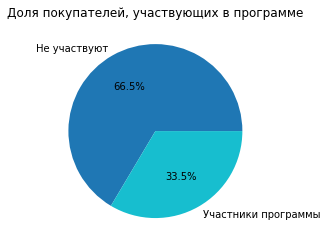

In [ ]:
x= [loyalty_no['customer'].nunique(), loyalty_yes['customer'].nunique()]
labels = ['Не участвуют', 'Участники программы']
colors = ['tab:blue', 'tab:cyan']
fig, ax = plt.subplots()
ax.pie(x, labels = labels, colors = colors, autopct='%1.1f%%')
ax.set_title('Доля покупателей, участвующих в программе')
plt.show()

**Доля покупателей, участвующий в пргорамме лояльности 33,5%**

### Определим даты исследования

In [ ]:
# определим границы дат покупок в исследуемых данных
min_date = retail['date'].min()
max_date = retail['date'].max()
days = (max_date - min_date).days +1 #посчитаем количество дней
print('Представлены данные с ', min_date, ' по ',  max_date)
print('Представлены данные за ', days, 'дней.')

Представлены данные с  2016-12-01 08:26:00  по  2017-02-28 17:04:00
Представлены данные за  90 дней.


Построим гисторгамму по дате и времени за 90 дней

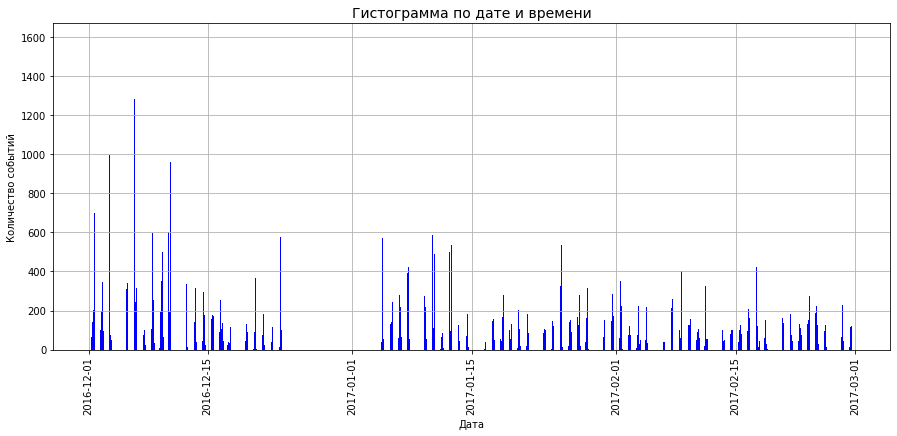

In [ ]:
plt.figure(figsize=(15, 6))
plt.hist(x = retail['date'], bins= days*24, color = 'blue')
plt.grid()
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Количество событий')
plt.title('Гистограмма по дате и времени', fontsize=14);

**Видим пропуски данных в конце декабря. Также, очевидно есть выходные дни, в которые нет продаж.**

### Сумма позиции в чеке

In [ ]:
#посчитаем сумму по позиции в чеке, добавим в новый столбец
retail['item_sum'] = retail['quantity'] * retail['price_per_one']
retail.head()
data=retail

### Нулевое количество

Мы занаем, что в данных очень много позиций с нулевым количеством. Это может повлиять на средний чек т.к увеличивает количество позиций в чеке, поэтому исследуем эти данные, чтобы решить, что делать с ними дальше

In [ ]:
q = retail.query('quantity == 0')
q['purchase_date'] = q['date'].dt.date
q

,purchase,item,quantity,date,customer,shop,loyalty,price_per_one,item_sum,purchase_date
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,3.290,0.0,2016-12-14
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,4.370,0.0,2017-02-09
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,5.750,0.0,2017-02-13
5,538379,22965,0,2016-12-12 11:26:00,22805,Shop 0,1,3.115,0.0,2016-12-12
6,540468,22189,0,2017-01-07 13:55:00,0,Shop 0,0,3.950,0.0,2017-01-07
...,...,...,...,...,...,...,...,...,...,...
104281,538073,22439,0,2016-12-09 14:10:00,23495,Shop 0,1,1.250,0.0,2016-12-09
104282,543306,22898,0,2017-02-07 11:56:00,22365,Shop 0,1,4.130,0.0,2017-02-07
104283,543013,22266,0,2017-02-02 13:35:00,0,Shop 0,0,0.950,0.0,2017-02-02
104294,538349,22625,0,2016-12-10 14:59:00,0,Shop 0,0,8.500,0.0,2016-12-10


Товары с нулевым количеством могут быть как бесплатными, так и иметь цену. Скорее всего это какие-то услуги, поскольку для товара была бы нулевая цена, а не количество.


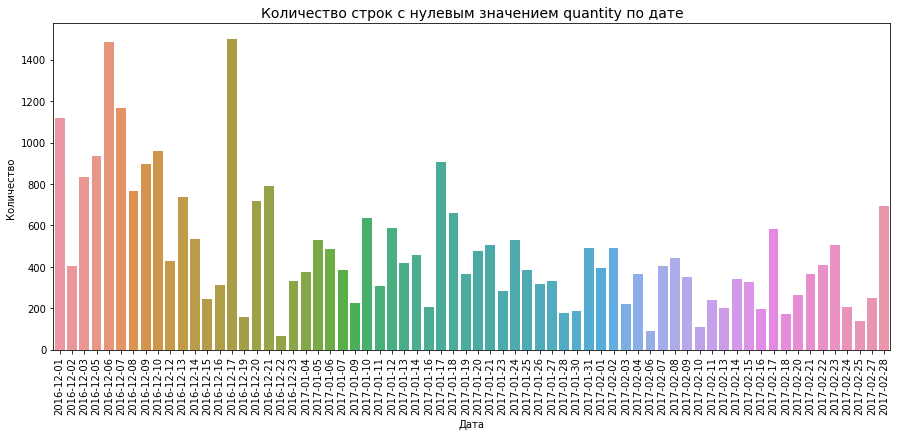

In [ ]:
plt.subplots(figsize=(15, 6))
f = sns.countplot(q['purchase_date'].sort_values())
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Количество ')
plt.title('Количество строк с нулевым значением quantity по дате', size= 14)
plt.show()

Большее колиечство данных с нулевым значением появлялось 6 и 17 декабря. Данные с нулевым количеством товара появлялись на протяжении всего периода. Нет никаких оснований полагать, что это технические ошибки или сбои систем.

Попробуем сгруппировать данные по товару

In [ ]:
q.groupby('item')['item'].count()

item
10002           18
10120            2
10123C           1
10125           13
10133            6
                ..
gift_0001_20     3
gift_0001_30     3
gift_0001_40     1
gift_0001_50     1
m                1
Name: item, Length: 2801, dtype: int64

2801 уникальный артикул имеет в данных значение количества 0 хотя бы 1 раз. Значит это не какие-то определенные ошибочные артикулы или не какие-либо конкретные услуги. Как минимум, видим, что это могут быть подарки (gift). Но возникает вопрос, почему подарки не просчитываются в системе по количеству.  

Посмотрим поближе данные по самому популярному товару с нулевым количеством

In [ ]:
q.query('item == "10002"')

,purchase,item,quantity,date,customer,shop,loyalty,price_per_one,item_sum,purchase_date
11006,537823,10002,0,2016-12-08 14:25:00,0,Shop 0,0,1.63,0.0,2016-12-08
11837,540418,10002,0,2017-01-07 11:04:00,0,Shop 0,0,1.63,0.0,2017-01-07
12326,544205,10002,0,2017-02-17 10:31:00,0,Shop 0,0,1.63,0.0,2017-02-17
20302,539451,10002,0,2016-12-17 16:59:00,0,Shop 0,0,1.63,0.0,2016-12-17
26499,543806,10002,0,2017-02-13 12:48:00,22764,Shop 0,1,1.63,0.0,2017-02-13
27698,537642,10002,0,2016-12-07 15:33:00,0,Shop 0,0,1.63,0.0,2016-12-07
33692,536863,10002,0,2016-12-03 11:19:00,23646,Shop 0,1,1.63,0.0,2016-12-03
39959,541878,10002,0,2017-01-24 10:28:00,0,Shop 0,0,1.63,0.0,2017-01-24
44531,543179,10002,0,2017-02-04 10:31:00,18433,Shop 14,0,1.63,0.0,2017-02-04
49285,538566,10002,0,2016-12-13 11:21:00,0,Shop 0,0,1.63,0.0,2016-12-13


Нет никакой связи между покупателем, количеством или участием в программе лояльности. Этот артикул есть как в чеках у известных покупателей, так и у покупателей без идентификатора, как у участников программы лояльности, так и у тех, кто в ней не состоит.  Также покупка проходит в разных магазинах.

Проверим этот же артикул в общих данных

In [ ]:
retail.query('item == "10002"').head(20)

,purchase,item,quantity,date,customer,shop,loyalty,price_per_one,item_sum
2181,537666,10002,1,2016-12-07 18:36:00,0,Shop 0,0,1.63,1.63
2798,538167,10002,11,2016-12-09 18:58:00,20392,Shop 0,0,1.63,17.93
6421,541094,10002,10,2017-01-13 13:36:00,18925,Shop 0,0,1.63,16.30
6922,540277,10002,59,2017-01-06 12:18:00,19937,Shop 0,0,1.63,96.17
9941,538071,10002,1,2016-12-09 14:09:00,0,Shop 0,0,1.63,1.63
11006,537823,10002,0,2016-12-08 14:25:00,0,Shop 0,0,1.63,0.00
11837,540418,10002,0,2017-01-07 11:04:00,0,Shop 0,0,1.63,0.00
12326,544205,10002,0,2017-02-17 10:31:00,0,Shop 0,0,1.63,0.00
12952,542610,10002,13,2017-01-30 14:05:00,18827,Shop 0,0,1.63,21.19
15877,541518,10002,11,2017-01-19 09:05:00,18130,Shop 7,0,1.63,17.93


Также не обнаружено никакой связи между количеством товара.

Попробуем сгруппировать по цене

In [ ]:
q.groupby('price_per_one')['item'].count().sort_values()


price_per_one
6706.710       1
5.950          1
20.790         1
0.825          1
6.110          1
            ... 
4.370        822
3.290        927
1.855        974
1.630       1037
2.460       1204
Name: item, Length: 484, dtype: int64

484 уникальных цены артикулов. То есть мы не можем четко сказать, что это какая-то конкретная скидка.

По каждой позиции в чеке должно отражаться движение стока. Если товар был продан даже за нулевую цену, то это должно отражаться в системе как 1. Если был возврат, то -1. Никаких точных данных у нас нет. Каких-либо связей нулевого количества с другими значениями не обнаружено. Поэтому мы вынуждены **удалить эти данные, как пустые и не учитывать их при расчете среднего чека.**

В реальной жизни необходимо уточнить у заказчика каким образом отражается в системе движение товара. В рамках проекта не удалось определить что это за данные, это может привести к искажению исследования, поскольку их очень большое количество.


In [ ]:
retail.query('quantity == 0').count()

purchase         32362
item             32362
quantity         32362
date             32362
customer         32362
shop             32362
loyalty          32362
price_per_one    32362
item_sum         32362
dtype: int64

In [ ]:
retail = retail.query('quantity != 0') #удаляем
retail.query('quantity == 0').count() #проверяем

purchase         0
item             0
quantity         0
date             0
customer         0
shop             0
loyalty          0
price_per_one    0
item_sum         0
dtype: int64

Посмотрим на графике распределение по количеству товаров

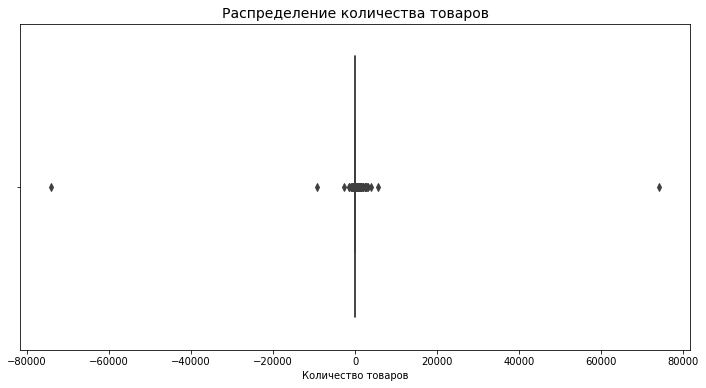

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = retail, x='quantity')
plt.title('Распределение количества товаров', size= 14)
plt.xlabel('Количество товаров')
plt.show()

In [ ]:
retail['quantity'].describe()

count    71940.000000
mean        11.429149
std        396.778322
min     -74216.000000
25%          1.000000
50%          5.000000
75%         11.000000
max      74214.000000
Name: quantity, dtype: float64

Пропасть значений между максимумом и 3 квартилем, что видим также по графику. Удалим явные выбросы, опираясь на график

In [ ]:
x = retail.query('quantity < -5000 | quantity > 20000')

In [ ]:
len(retail)

71940

In [ ]:
retail = retail[retail.purchase.isin(x['purchase']) == False]

In [ ]:
len(retail)

71937

In [ ]:
retail['quantity'].describe()

count    71937.000000
mean        11.559781
std         55.552321
min      -2601.000000
25%          1.000000
50%          5.000000
75%         11.000000
max       5567.000000
Name: quantity, dtype: float64

**Удалили выбросы по количеству товаров.**

In [ ]:
retail.head()

,purchase,item,quantity,date,customer,shop,loyalty,price_per_one,item_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.630,17.930
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,1.630,11.410
7,541424,79321,1,2017-01-17 17:57:00,0,Shop 0,0,5.750,5.750
10,537795,82494L,5,2016-12-08 13:03:00,22892,Shop 0,1,5.205,26.025
11,541696,22197,4,2017-01-20 18:08:00,0,Shop 0,0,1.240,4.960


### Отрицательное количество

Отрицательное количество в данных чеков, скорее всего, говорит о возврате товаров. Раз количество отрицательное, то это и сумма по позиции отрицательная. Но она может быть скомпенсирована другими позициями в чеке. Посчитаем сумму чеков и проверим много ли в данных отрицательных сумм чеков.

In [ ]:
minus = retail.query('quantity < 0')
minus['item'].nunique()
print('Количество строк в данных с отрицательным колиечеством товара', len(minus))
print('Количество уникальных товаров с отрицательным колиечеством', minus['item'].nunique() )

Количество строк в данных с отрицательным колиечеством товара 2074
Количество уникальных товаров с отрицательным колиечеством 949


In [ ]:
#строим таблицу с группировкой по чеку
purchase = retail.groupby(['purchase', 'customer', 'loyalty', 'date']).agg({'item_sum': 'sum', 'item': 'count'}).reset_index()
purchase['date']= pd.to_datetime(purchase['date'], format='%Y-%m-%d %H:%M:%S')
purchase['date']= purchase['date'].dt.date
days_sum = purchase.groupby('date').agg({'item_sum': 'sum'}).reset_index()


Проверим есть ли отрицательные значения сумм чеков в разрезе дней, т.е. есть ли дни, когда магазин уходит в минус.

In [ ]:
days_sum.query('item_sum < 0')

,date,item_sum


Таких значений не обнаружено.

Используя таблицу посмотрим, какие дни были самыми прибыльными для магазина

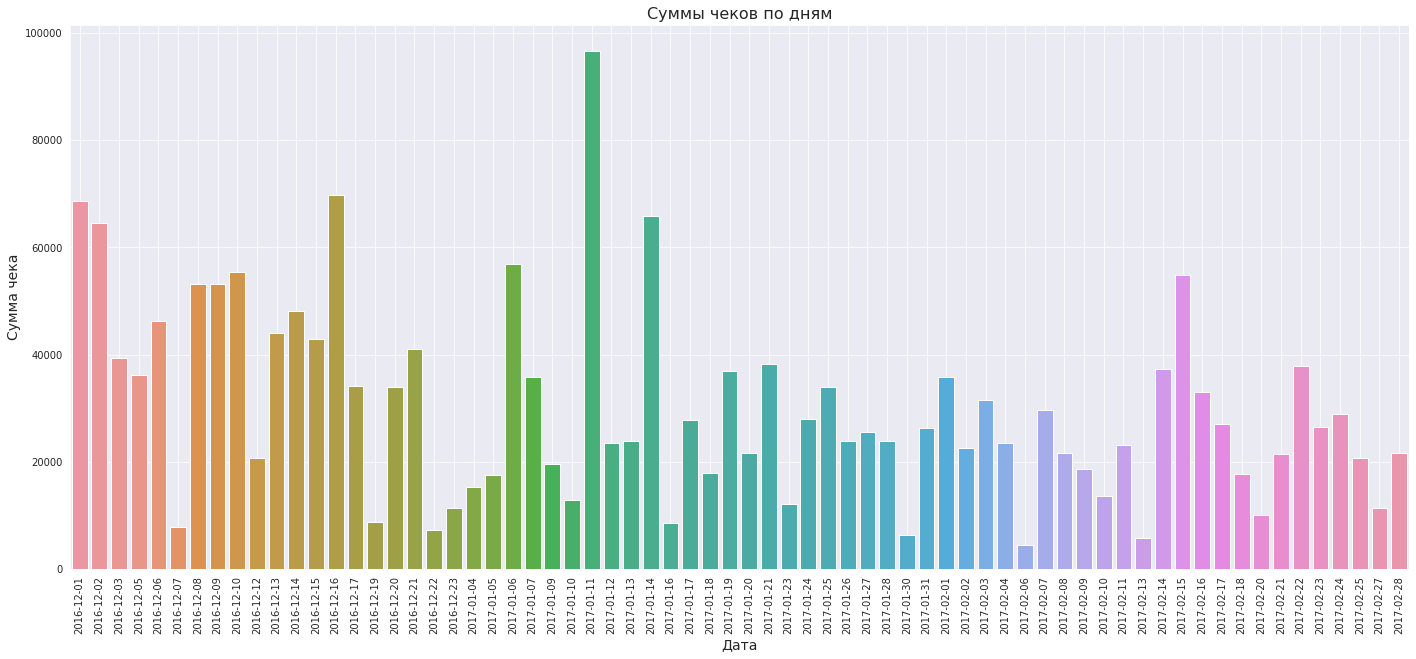

In [ ]:
# используем стиль dark из библиотеки seaborn
sns.set_style('dark')
# назначаем размер графика
plt.figure(figsize=(24, 10))
# строим столбчатый график средствами seaborn
sns.barplot(x='date', y='item_sum', data=days_sum)
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Суммы чеков по дням', size = 16)
plt.xlabel('Дата',  size = 14)
plt.ylabel('Сумма чека', size = 14)
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=90)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

Самый прибыльный день 11 января, меньше всего магазин получил 6 февраля.


**Оставим данные с отрицательным колитчеством. Суммы таких позиций повлияют на средний чек.**

### Сумма чеков

In [ ]:
retail = retail.query('customer > 0')

На этом этапе нам необходимо избавится от неидентифицированнных покупателей, поскольку при формировании таблицы для расчета LTV , такие даныые исказят исследование.

Сформируем таблицу с группировкой по чеку, посчитаем сумму чека

In [ ]:
purchase.describe()

,customer,loyalty,item_sum,item
count,4738.000000,4738.000000,4738.000000,4738.000000
mean,18107.962431,0.281553,435.414574,15.182989
std,7352.582892,0.449804,1436.870457,25.947042
min,0.000000,0.000000,-13413.420000,1.000000
25%,18732.500000,0.000000,15.740000,2.000000
50%,20412.000000,0.000000,215.635000,8.000000
75%,22251.250000,1.000000,506.648750,18.000000
max,23962.000000,1.000000,26374.580000,331.000000


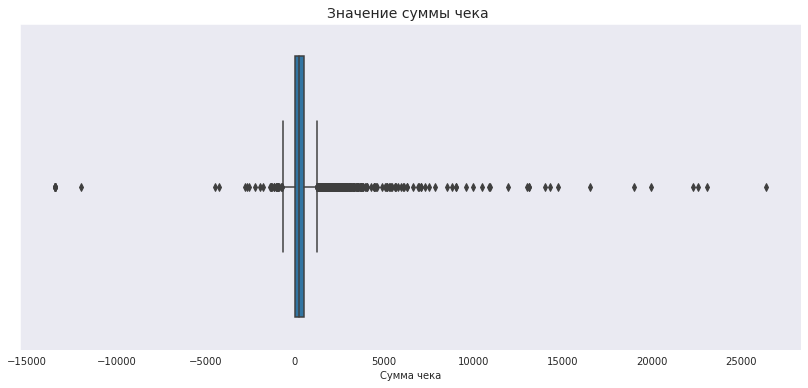

In [ ]:
ax = plt.figure(figsize=(14, 6))
ax = sns.boxplot(x='item_sum',  data=purchase)
#ax.set_ylim([-10, 5000])
plt.title('Значение суммы чека ', size = 14)
plt.xlabel('Сумма чека')
plt.show()

Видим большой разброс значений. Если удалять выбросы по третьему квартилю, то придется избавится от половины чеков. Это делать не будем. Удалим аномальные значения, ориентируясь на график

In [ ]:
len(purchase)

4738

In [ ]:
purchase = purchase.query('item_sum > -5000 & item_sum < 10000')
len(purchase)

4710

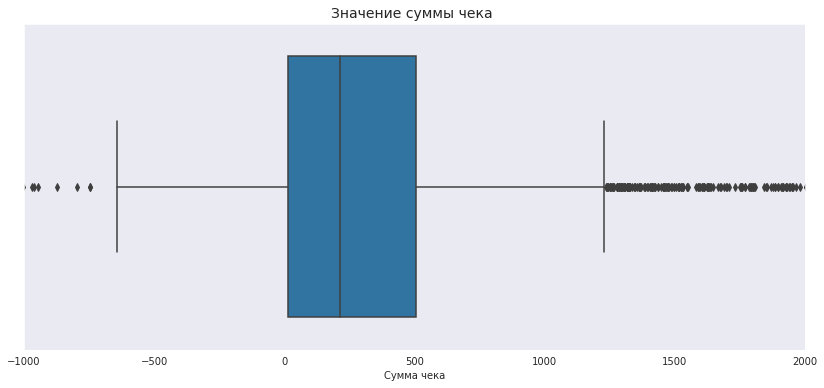

In [ ]:
ax = plt.figure(figsize=(14, 6))
ax = sns.boxplot(x='item_sum',  data=purchase)
ax.set_xlim([-1000, 2000])
plt.title('Значение суммы чека ', size = 14)
plt.xlabel('Сумма чека')
plt.show()

In [ ]:
purchase.describe()

,customer,loyalty,item_sum,item
count,4710.000000,4710.000000,4710.000000,4710.000000
mean,18149.321444,0.282378,410.337244,15.092569
std,7310.424254,0.450204,804.806977,25.821198
min,0.000000,0.000000,-4497.495000,1.000000
25%,18750.000000,0.000000,15.900000,2.000000
50%,20414.000000,0.000000,214.635000,8.000000
75%,22268.750000,1.000000,503.968750,18.000000
max,23962.000000,1.000000,9969.210000,331.000000


**Медианное занчение суммы чека 214.6 рубля. Максимальное значение 9969.2 руб., минимальное -4497,5 руб. Среднее значение суммы чека 410 руб**

**Медианное количество артикулов в чеке 8 шт., максимальное 331 шт., минимальное 1 шт. Среднее количество артикулов в чеке 15**

### Найдем значение среднего чека

In [ ]:
print('Средний чек по всем данным', round((purchase['item_sum'].sum())/ purchase['purchase'].count(),2))

Средний чек по всем данным 410.34


**Вывод:**

**Представлены данные за 90 дней с  2016-12-01  по  2017-02-28**

- Всего в данных 1750 уникальных покупателя. Из них 33,5% имеют карту лояльности.
- Средний чек по всем данным 410.34
- Всего 4095 уникальных чека
- Максимальное значение суммы чека 9969.2 руб., минимальное -4497,5 руб.
- Медианное количество артикулов в чеке 8 шт., максимальное 331 шт., минимальное 1 шт.
- Удалили выбросы по количеству товаров и покупатели без идентификаторов

## Анализ программы лояльности

### Расчет пожизненной ценности покупателя LTV

Сформируем таблицу для профилей покупателей, добавим столбец с первой датой покупки

In [ ]:
profiles = retail.groupby('customer').agg({'date' : np.min}).reset_index()
profiles = profiles.rename(columns={'date':'first_ts'})
profiles['first_ts']= pd.to_datetime(profiles['first_ts'], format='%Y-%m-%d %H:%M:%S')
profiles['dt']= profiles['first_ts'].dt.date
profiles.head()

,customer,first_ts,dt
0,18026,2016-12-07 14:57:00,2016-12-07
1,18027,2016-12-16 19:09:00,2016-12-16
2,18029,2017-02-02 16:01:00,2017-02-02
3,18031,2017-02-16 12:33:00,2017-02-16
4,18035,2017-01-18 09:50:00,2017-01-18


В таблице с чеками изменим формат даты

In [ ]:
# purchase['date']= pd.to_datetime(purchase['date'], format='%Y-%m-%d %H:%M:%S')
# purchase['date']= purchase['date'].dt.date

In [ ]:
purchase.head(1)

,purchase,customer,loyalty,date,item_sum,item
0,536365,23529,1,2016-12-01,186.515,7


Для того, чтобы добавить 200 руб. к чеку лояльных покупателей за первую покупку в месяце, сначала найдем все необходимые значения чеков, к которым будем их добавлять. Для этого построим табличку а

In [ ]:
purchase['month'] = purchase['date'].astype('datetime64[M]')
a = purchase .groupby([ 'month','purchase', 'customer', 'loyalty']).agg({'item': 'count', 'date': np.min}).reset_index()
a = a.query('loyalty == 1') #нам нужны только лояльные
a = a.drop_duplicates(['customer', 'date']) # удалим дубликаты тех, кто в первый день сделал покупку больше 1 раза
#a = a['purchase']. tolist ()
a['card'] = 200 #добавим столбец с 200 руб
a.head(1)

,month,purchase,customer,loyalty,item,date,card
0,2016-12-01,536365,23529,1,1,2016-12-01,200


In [ ]:
#соединим с таблицей с чеками
purchase = pd.merge(purchase, a, on = 'purchase', how='left')
purchase.rename(columns={'customer_x': 'customer', 'loyalty_x': 'loyalty', 'item_x': 'item', 'date_x': 'date', 'month_x':'month',\
                         'customer_y': 'customer_a', 'loyalty_y': 'loyalty_a', 'item_y': 'item_a',\
                         'date_y': 'date_a', 'card_x': 'card'}, inplace=True)
#purchase = purchase.drop(columns='month_y', 'customer_a', 'loyalty_a', 'item_a', 'date_a')
purchase['card'] = purchase['card'].fillna(0) # все значения NaN заменим на 0
purchase['total'] = purchase['item_sum'] + purchase['card']# добавим новый столбец в котором посчитаем общ сумму
purchase.head(1)

,purchase,customer,loyalty,date,item_sum,item,month,month_y,customer_a,loyalty_a,item_a,date_a,card,total
0,536365,23529,1,2016-12-01,186.515,7,2016-12-01,2016-12-01,23529.0,1.0,1.0,2016-12-01,200.0,386.515


Расчитаем LTV с помощью функции. Возьмем горизонт событий равный 60 дней, т.е рассмотрим покупателей, которые "прожили" это время. Рассмотрим LTV в разрезе программы лояльности.

In [ ]:
#функция сглаживания
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df
#функция для расчета LTV
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchase,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['loyalty'] + dimensions
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchase[['customer', 'date', 'total', 'loyalty']],
        on='customer',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['date'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 4. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='total',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 5. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 6. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer': 'nunique'})
            .rename(columns={'customer': 'cohort_size'})
        )

        # Шаг 7. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 8. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

     # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
#функция построения графика
def plot_ltv(ltv, ltv_history, horizon, window=7):

    plt.figure(figsize=(24, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм', size=16)
    plt.title('LTV', size=16)

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Дата привлечения', size=16)
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon), size=16)

    plt.tight_layout()
    plt.show()

In [ ]:
# преобразуем данные о времени
profiles['dt'] = pd.to_datetime(profiles['dt'])
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
purchase['date'] = pd.to_datetime(purchase['date'])

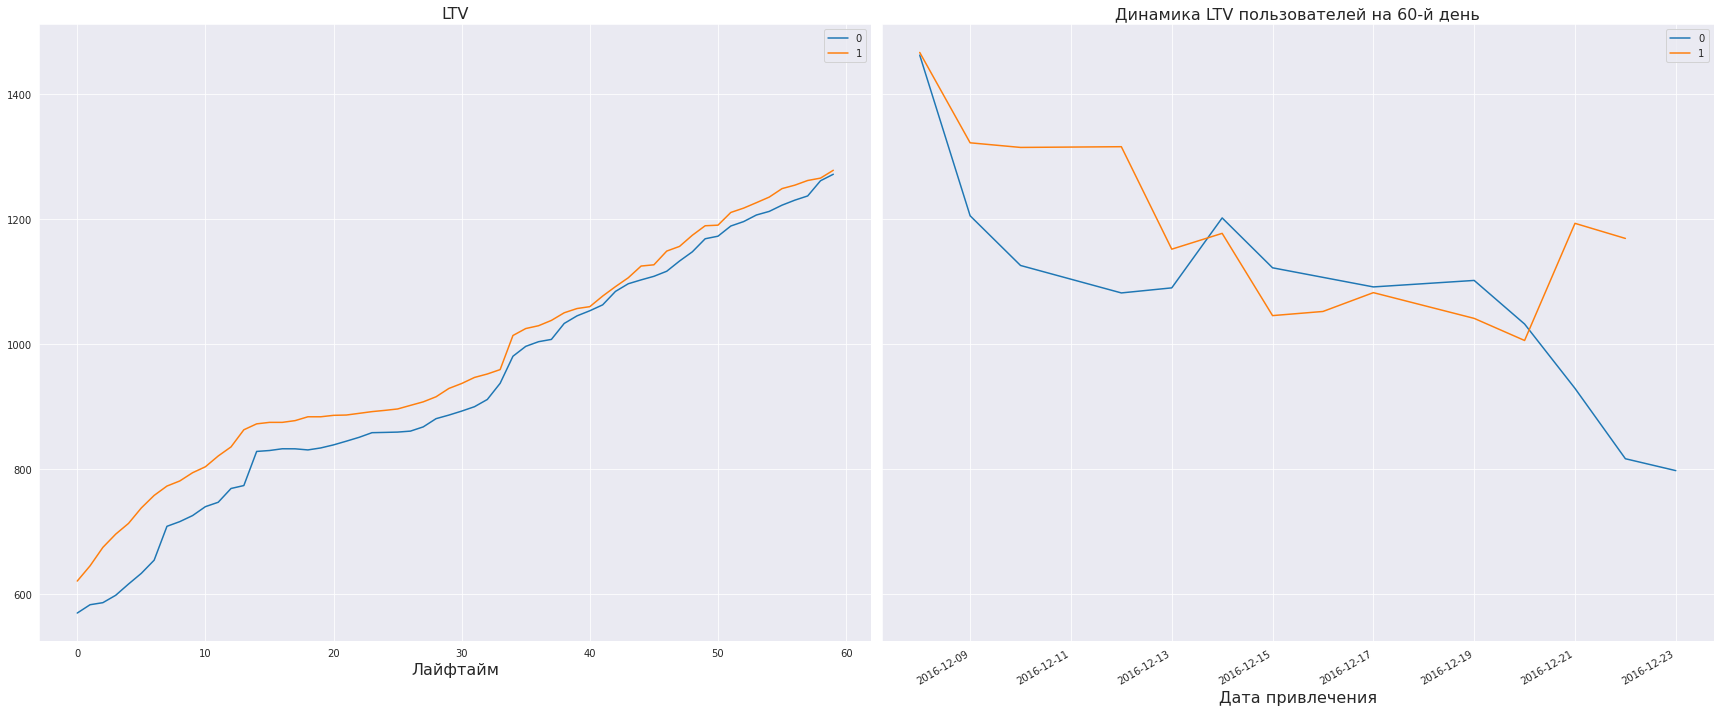

In [ ]:
observation_date= datetime(2017, 2, 28).date()
horizon_days =60
profiles= profiles
purchese= purchase
ltv_raw, ltv_grouped, ltv_history= get_ltv(
    profiles, purchase, observation_date, horizon_days
    )

plot_ltv(ltv_grouped, ltv_history, horizon_days)


**Судя по графику, LTV — у пользователей без карт выше, чем у участников программы лояльности. LTV достаточно стабилен.**

**Динамика LTV к 60 дню снижается в обеих группах. Однако у покупателей с картами они более равномерная.**

****

### Суммы чеков по группам лояльности

Построим график распределения сумм чеков по месяцам и группам лояльности

In [ ]:
purchase['month'] = purchase['date'].astype('datetime64[M]')

In [ ]:
purchase['month1'] = purchase['month'].dt.strftime('%b %Y')
purchase['day'] = purchase['date'].dt.date
l0 = purchase.query('loyalty == 0').groupby('month1').agg({'total': 'sum'})
l1 = purchase.query('loyalty == 1').groupby('month1').agg({'total': 'sum'})
l = pd.merge(l0, l1, on = 'month1', how='left').reset_index()
l.rename(columns={'total_x': '0', 'total_y': '1'}, inplace=True)
l

,month1,0,1
0,Dec 2016,596321.755,302292.920
1,Feb 2017,366311.455,245912.660
2,Jan 2017,460058.015,195991.615


<Figure size 432x288 with 0 Axes>

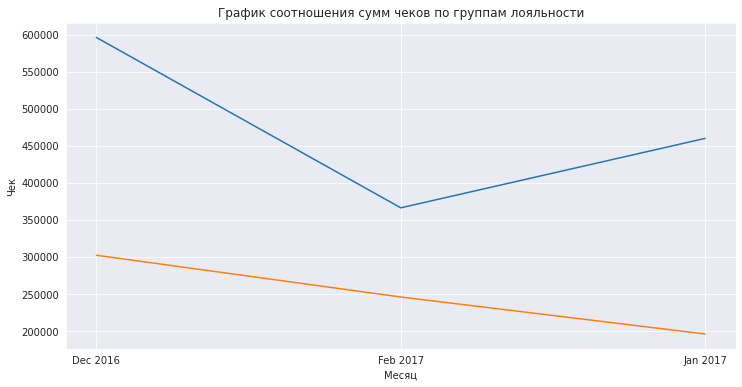

In [ ]:
plt.figure()

x = l['month1']
y1 = l['0']
y2 = l['1']
plt.figure(figsize=(12, 6))
plt.grid()
plt.title('График соотношения сумм чеков по группам лояльности')
plt.xlabel('Месяц')
plt.ylabel('Чек')

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

Все три месяца покупатели без карт приносили магазину в общем большую выгоду, чем с картами.Каждый месяц прибыль от лояльных покупателей уменьшается. При этом сумма чеков покупателей без карт растет в феврале после просадки в январе.

###  Средний чек

Сформируем общую таблицу для удобства расчетов.

In [ ]:
#посчитаем средний чек и добавим его к основному датасету
retail = pd.merge(retail, purchase, on = 'purchase', how='left')
retail.rename(columns={'item_sum_x': 'item_sum', 'item_sum_y': 'total_sum'}, inplace=True)
retail.head()

,purchase,item_x,quantity,date_x,customer_x,shop,loyalty_x,price_per_one,item_sum,customer_y,...,month,month_y,customer_a,loyalty_a,item_a,date_a,card,total,month1,day
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.630,17.930,18427.0,...,2016-12-01,NaT,NaN,NaN,NaN,NaN,0.0,1130.465,Dec 2016,2016-12-10
1,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,1.630,11.410,22182.0,...,2016-12-01,2016-12-01,22182.0,1.0,1.0,2016-12-14,200.0,806.185,Dec 2016,2016-12-14
2,537795,82494L,5,2016-12-08 13:03:00,22892,Shop 0,1,5.205,26.025,22892.0,...,2016-12-01,2016-12-01,22892.0,1.0,1.0,2016-12-08,200.0,505.315,Dec 2016,2016-12-08
3,543647,21987,3,2017-02-10 19:49:00,18520,Shop 0,0,0.650,1.950,18520.0,...,2017-02-01,NaT,NaN,NaN,NaN,NaN,0.0,95.920,Feb 2017,2017-02-10
4,538533,22294,9,2016-12-13 10:31:00,20475,Shop 0,0,1.855,16.695,20475.0,...,2016-12-01,NaT,NaN,NaN,NaN,NaN,0.0,470.480,Dec 2016,2016-12-13


In [ ]:
# Создадим здесь датасет без возвратов, он пригодится нам позже для расчета чистого среднего чека.
plus = retail.query('quantity > 0')

#### Построим график среднего чека по дням в разрезе групп лояльности

In [ ]:
# создаем таблицу с группировкой чеков по дням
average_day = retail.drop_duplicates(subset='purchase').groupby(['date_y', 'loyalty_y'])\
                              .agg({'total_sum': 'median'}).reset_index()


In [ ]:
#создаем датасет со всеми днями исследования
df = pd.date_range (start='2016-12-01', end='2017-02-28')
df = pd.DataFrame(df, columns = ['date_y'])
df['date_y'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date_y  90 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 848.0 bytes


In [ ]:
#соединяем две таблицы, чтобы получить одну, включающую в себя дни без продаж
average_day = pd.merge(average_day, df, on = 'date_y', how='right')
average_day['loyalty_y'] = average_day['loyalty_y'].fillna(0) # заменяем NaN на 0
average_day['total_sum'] = average_day['total_sum'].fillna(0)
average_day['date_y']= average_day['date_y'].dt.date
average_day.head(1)

,date_y,loyalty_y,total_sum
0,2016-12-01,0.0,398.54


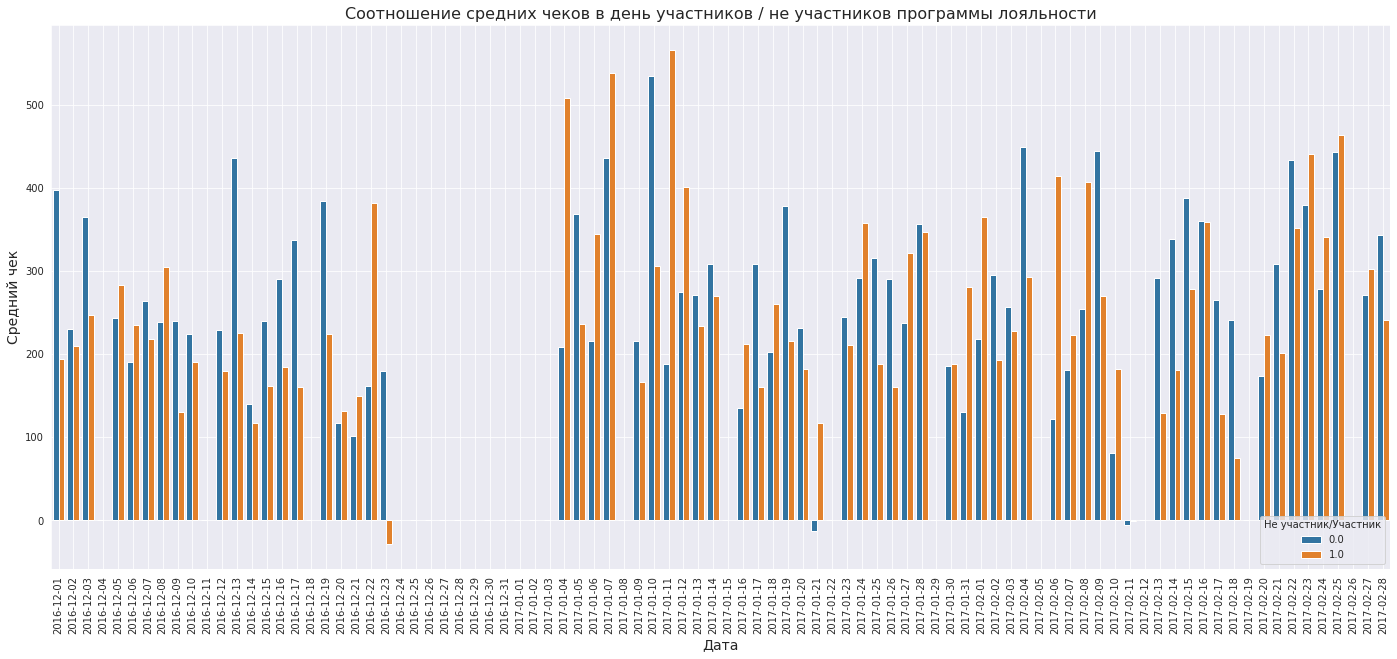

In [ ]:
# используем стиль dark из библиотеки seaborn
sns.set_style('dark')
# назначаем размер графика
plt.figure(figsize=(24, 10))
# строим столбчатый график средствами seaborn
sns.barplot(x='date_y', y='total_sum', data=average_day, hue='loyalty_y')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Соотношение средних чеков в день участников / не участников программы лояльности', size = 16)
plt.xlabel('Дата',  size = 14)
plt.ylabel('Средний чек', size = 14)
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=90)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10, title='Не участник/Участник' )
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

До середины декабря преобладают более высокие показатели группы без карт.

Соотношение средних чеков по дням переменчиво. Нет четкой картины, что с картой лояльности всегда покупают больше или меньше. Есть дни, когда это так, есть дня, где наоборот.

23 декабря средний чек покупателей с картами падает ниже нуля после сильного роста 22 декабря. Это может говорить о том, что покупатели сделали большое количество возвратов товаров, которые были приобритены ранее. Можно предположить, что прошла какая-то акция на товар, а возврат связан с качеством самого товара (как пример).


#### Построим график среднего чека по месяцам в разрезе групп лояльности

In [ ]:
average_month = retail.drop_duplicates(subset='purchase').groupby(['month', 'loyalty_y'])\
                              .agg({'total_sum': 'median'}).reset_index()
average_month

,month,loyalty_y,total_sum
0,2016-12-01,0.0,244.755
1,2016-12-01,1.0,194.785
2,2017-01-01,0.0,267.305
3,2017-01-01,1.0,254.290
4,2017-02-01,0.0,284.175
5,2017-02-01,1.0,270.625


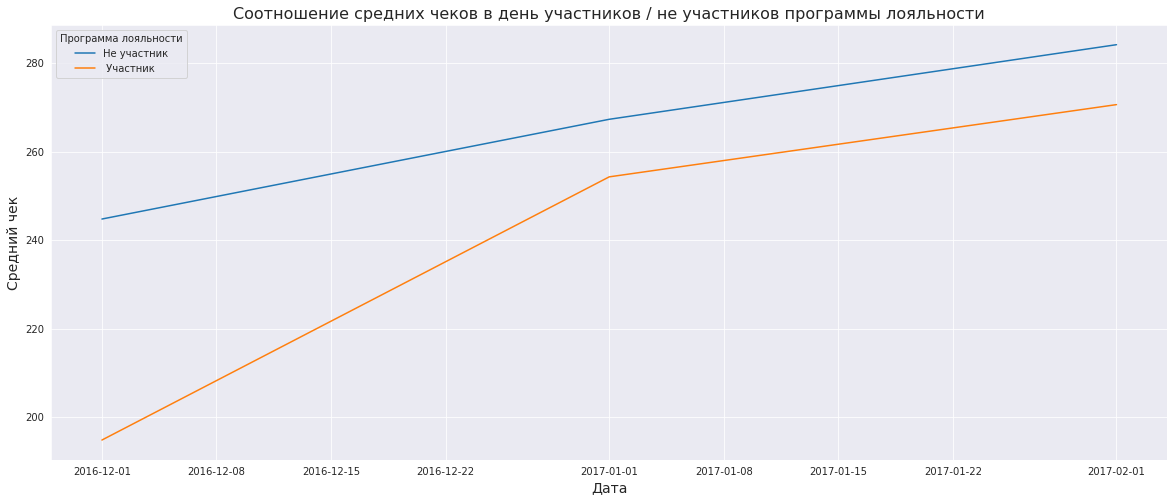

In [ ]:
plt.subplots(figsize = (20, 8))
sns.lineplot(x='month', y='total_sum', hue = 'loyalty_y', data = average_month)
plt.legend(title='Программа лояльности',  labels=['Не участник', ' Участник'])
plt.grid()
plt.title('Соотношение средних чеков в день участников / не участников программы лояльности', size = 16)
plt.ylabel('Средний чек', size = 14)
plt.xlabel('Дата',  size = 14)
plt.show()

Здесь на графике четко определяется лидирующая группа. Не участвующие в программе лояльности покупатели имеют больший средний чек в течение трех месяцев.
Средний чек обеих групп увеличивался все время исследования.

### Сравнение показателей за декабрь

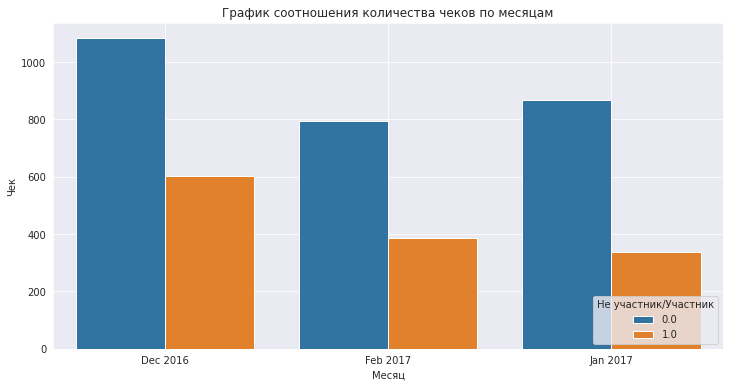

In [ ]:
check = retail.drop_duplicates(subset='purchase')\
            .groupby(['month1','loyalty_y'])\
            .agg({'purchase': 'nunique'}).reset_index()

# используем стиль dark из библиотеки seaborn
sns.set_style('dark')
# назначаем размер графика
plt.figure(figsize=(12, 6))
# строим столбчатый график средствами seaborn
sns.barplot(x='month1', y='purchase', data=check, hue='loyalty_y')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('График соотношения количества чеков по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Чек')
# поворачиваем подписи значений по оси X на 45 градусов
#plt.xticks(rotation=45)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10, title='Не участник/Участник' )
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

**По исследованным данным мы можем сказать, что:**
- Общая сумма покупок за декабрь больше, чем за другие месяцы, без карт лояльности и меньше, чем в другие месяцы по картам.
- Общая сумма покупок лояльных покупателей меньше, чем нелояльных
- Средний чек до 22 декабря у покупателей без карт почти всегда выше.
- 22 декабря есть скачок по лояльным клиентам, но 23 сильный спад среднего чека, скорее всего большое количество возвратов
- Средний чек по декабрю ниже остальных месяцев
- Количество чеков самое большое как по покупателям без карт, так и по картам


**По этим данным, можно предположить, что коммерческие мероприятия декабря не были удачными. Несмотря на большое количество покупок, общая сумма и средний чек по декабрю самые низкие, что может говорить о большой количистве возвратов.**

In [ ]:
# создаем таблицу с группировкой чеков по дням без возвратов
average_day_plus = plus.drop_duplicates(subset='purchase').groupby(['date_y', 'loyalty_y'])\
                              .agg({'total_sum': 'median'}).reset_index()
#соединяем две таблицы, чтобы получить одну, включающую в себя дни без продаж
average_day_plus = pd.merge(average_day_plus, df, on = 'date_y', how='right')
average_day_plus['loyalty_y'] = average_day_plus['loyalty_y'].fillna(0) # заменяем NaN на 0
average_day_plus['total_sum'] = average_day_plus['total_sum'].fillna(0)
average_day_plus['date_y']= average_day_plus['date_y'].dt.date
average_day_plus.head(1)

,date_y,loyalty_y,total_sum
0,2016-12-01,0.0,403.82


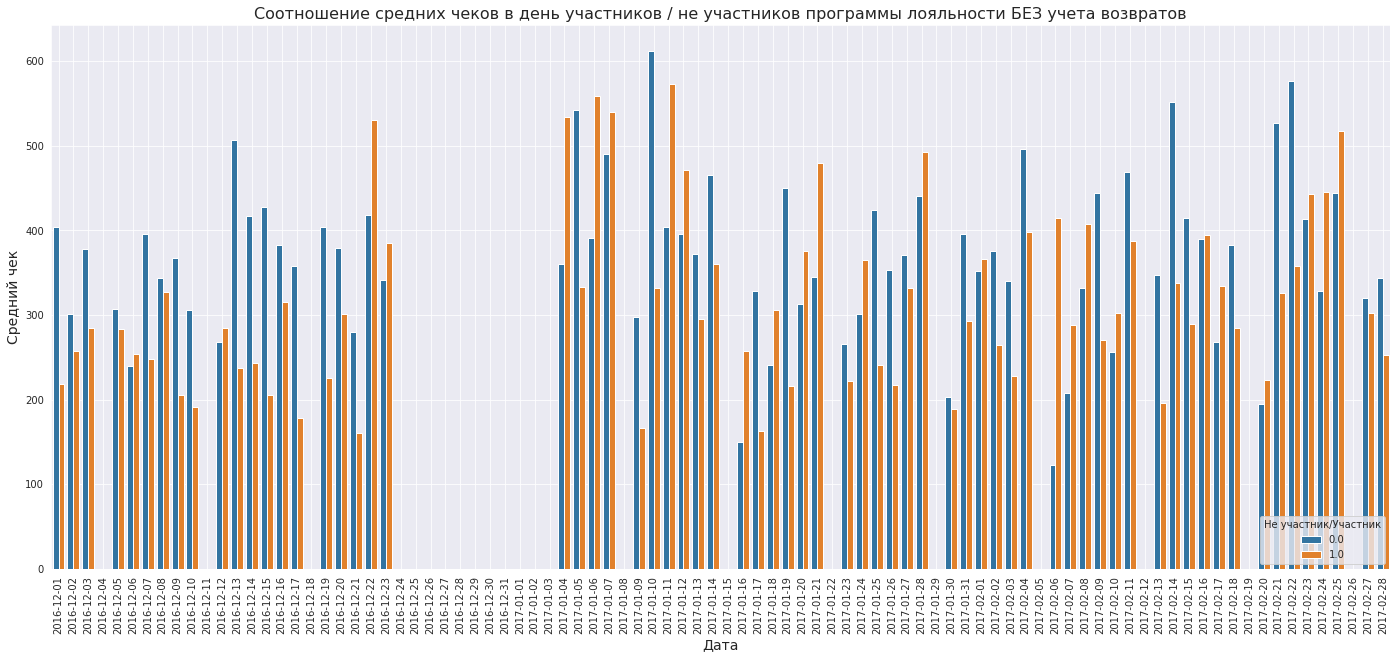

In [ ]:
# используем стиль dark из библиотеки seaborn
sns.set_style('dark')
# назначаем размер графика
plt.figure(figsize=(24, 10))
# строим столбчатый график средствами seaborn
sns.barplot(x='date_y', y='total_sum', data=average_day_plus, hue='loyalty_y')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Соотношение средних чеков в день участников / не участников программы лояльности БЕЗ учета возвратов', size = 16)
plt.xlabel('Дата',  size = 14)
plt.ylabel('Средний чек', size = 14)
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=90)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10, title='Не участник/Участник' )
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

In [ ]:
purchase = data.query('quantity > 0').groupby(['purchase', 'customer', 'loyalty', 'date'])\
                .agg({'item_sum': 'sum'}).reset_index()
purchase['month'] = purchase['date'].astype('datetime64[M]')
purchase['month1'] = purchase['month'].dt.strftime('%b %Y')
purchase['day'] = purchase['date'].dt.date
l0 = purchase.query('loyalty == 0').groupby('month1').agg({'item_sum': 'sum'})
l1 = purchase.query('loyalty == 1').groupby('month1').agg({'item_sum': 'sum'})
l = pd.merge(l0, l1, on = 'month1', how='left').reset_index()
l.rename(columns={'item_sum_x': '0', 'item_sum_y': '1'}, inplace=True)
l

,month1,0,1
0,Dec 2016,657776.87,249957.38
1,Feb 2017,450169.62,190041.10
2,Jan 2017,700429.30,151422.20


<Figure size 432x288 with 0 Axes>

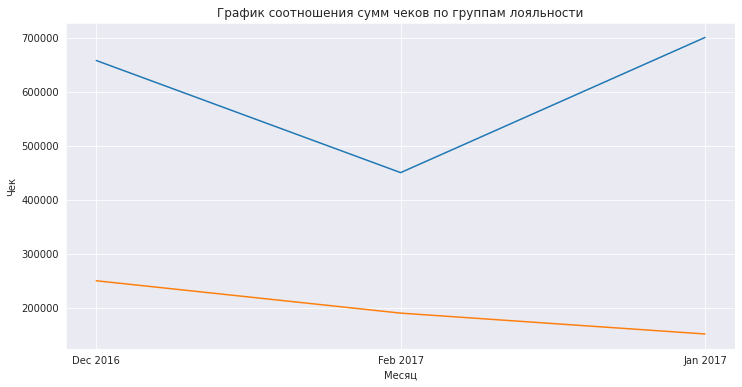

In [ ]:
plt.figure()

x = l['month1']
y1 = l['0']
y2 = l['1']
plt.figure(figsize=(12, 6))
plt.grid()
plt.title('График соотношения сумм чеков по группам лояльности')
plt.xlabel('Месяц')
plt.ylabel('Чек')

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

Без учета минусовых позиций количества общая картина не меняется. Покупатели без карт приносят магазину меньше прибыли и прибыль уменьшается с течением времени. У покупаетлей без карт сумма всех чеков за месяц уменьшилась в январе, но  сильно увеличилась в феврале и обогнала даже декабрьские показатели.

## Проверка гипотез

Подготовим данные

In [ ]:
df= retail.groupby(['loyalty_y', 'customer_y']).agg({'purchase': 'nunique', 'item_sum':'sum', 'quantity':'sum'}).reset_index()
df.columns = ['loyalty', 'customer', 'purchase_count', 'total_sum', 'quantity_sum']
df['avg_purchase'] = round(df['total_sum'] / df['purchase_count'], 2)
df['avg_quantity'] = round(df['quantity_sum'] / df['purchase_count'], 2)
df.head()

,loyalty,customer,purchase_count,total_sum,quantity_sum,avg_purchase,avg_quantity
0,0.0,18026.0,2,1736.520,574,868.26,287.0
1,0.0,18027.0,2,2004.205,1832,1002.10,916.0
2,0.0,18029.0,1,386.180,180,386.18,180.0
3,0.0,18031.0,1,390.170,83,390.17,83.0
4,0.0,18035.0,1,3559.810,1180,3559.81,1180.0


Разделим участников на группы по программе лояльности

In [ ]:
l0 = df.query('loyalty == 0').reset_index(drop=True)
l1 = df.query('loyalty == 1').reset_index(drop=True)

Будем использовать для тестирования критерий Манна-Уитни т.к. в данных есть большие выбросы, алгебраические метрики работают плохо, одно выбивающееся значение существенно влияет на результат. Это непараметрическй метод, поэтому к нему прибегают тогда, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих параметрические результаты. В нашем случае критерий Манна-Уитни должен более вероятно найти статистически значимый эффект.

### Гипотеза 1

>**Нулевая гипотеза H0:** средний чек при участии в программе лояльности равен среднему чеку без участия в программе лояльности

>**Альтернативная гипотеза H1:** средний чек при участии в программе лояльности отличается от среднего чека без участия в программе лояльности

In [ ]:
alpha = .05

results = st.mannwhitneyu(l0['avg_purchase'], l1['avg_purchase'])

print('p-значение:', '{0:.3f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не удалось отвергнуть нулевую гипотезу")
print('Относительная разница = {0:.1%}'.format(l0['avg_purchase'].mean()/l1['avg_purchase'].mean()-1))

p-значение: 0.002
Отвергаем нулевую гипотезу
Относительная разница = 20.5%


**p-value = 0.002 Это меньше 0.05. Отвергаем нулевую гипотезу. Средний чек неучаствующих в программе лояльности выше, чем у держателей карт.**

### Гипотеза 2

>**Нулевая гипотеза H0:** среднее количество товаров в чеке участников в программе лояльности равно среднему количеству товаров в чеке без участия в программе лояльности

>**Альтернативная гипотеза H1:** среднее количество товаров в чеке участников в программе лояльности отличается от среднего количества товаров в чеке без участия в программе лояльности

In [ ]:
alpha = .05

results = st.mannwhitneyu(l0['avg_quantity'], l1['avg_quantity'])

print('p-значение:', '{0:.3f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не удалось отвергнуть нулевую гипотезу")
print('Относительная разница = {0:.1%}'.format(l0['avg_quantity'].mean()/l1['avg_quantity'].mean()-1))

p-значение: 0.020
Отвергаем нулевую гипотезу
Относительная разница = 6.9%


**p-value 0.020, это меньше alpha = 0.5 значит между выборками существует стистическая значимость. Среднее количество товаров в чеках покупателей без карт выше, чем у держателей карт**

## Вывод и рекомендации


**Программа лояльности работает, но может стать эффективнее.**

Что мы узнали:
- Наличие карты не влияет на повышение среднего чека, количества товаров в чеке.
- Cредний доход на пользователя, участвующего в программе лояльности значительно ниже.
- В течение исследуемого пеориода покупатели без карт приносили магазину в общем большую выгоду, чем с картами.
- Пожизненная ценность покупателей без карт выше, чем у участников программы лояльности
- Наличие карты лояльности не оказало положительного влияния на коммерческие мероприятия в декабре.
- По графику соотношения сумм по месяцам, видим, что общая сумма покупателей с картой падает с каждым месяцем.


Что мы можем сделать:
- Т.к. цель программы лояльности сбор, анализ и сегментация клиентской базы,улучшение экономических показателей клиентов, необходимо в первую очередь усовершенствовать сбор данных. Изучить механику движения стока и идентификацию покупателей.
- Следует изучить окупаемость бесплатных позиций в чеках. Это поможет сегментировать клиентскую базу по определенным признакам, уведомлять об акциях и индивидуальных предложениях.
- Возможно стоит пересмотреть условия программы лояльности и ее продвижения
- Пересмотреть политику возвратов по карте лояльности
- Покупки с картой составляли основную часть продаж в празднечные дни до нового года и после, значит есть потенциал в составлении коммерческих мероприятий и в другие перо=иоды.
- Возможно пересмотреть предложения по карте лояльности и сделать их более интересными для покупателя.
- Желательно рассмотреть данные за более продолжительный период, чтобы посчитать другие пользовательские метрики, кооторые бы помогли более точно определеить влияние программы лояльности на выручку.
